In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01f0)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [5]:
spk_args = SpikingArgs(threshold = 0.001f0,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing, Missing}) (generic function with 1 method)

In [7]:
args = Args(batchsize = 128, epochs = 20, use_cuda = true)

Args(0.0003, 128, 20, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [8]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 20
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2]);

In [9]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [10]:
train_data = MLDatasets.FashionMNIST(split=:train)
test_data = MLDatasets.FashionMNIST(split=:test)

dataset FashionMNIST:
  metadata  =>    Dict{String, Any} with 4 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

In [11]:
train_loader =DataLoader(train_data, batchsize=args.batchsize)

469-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [12]:
test_loader =DataLoader(test_data, batchsize=args.batchsize)

79-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [13]:
x0, y0 = first(train_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 0, 0, 3, 0, 2, 7, 2, 5, 5  …  6, 7, 5, 5, 9, 2, 2, 2, 7, 6])

In [14]:
x0 |> size

(28, 28, 128)

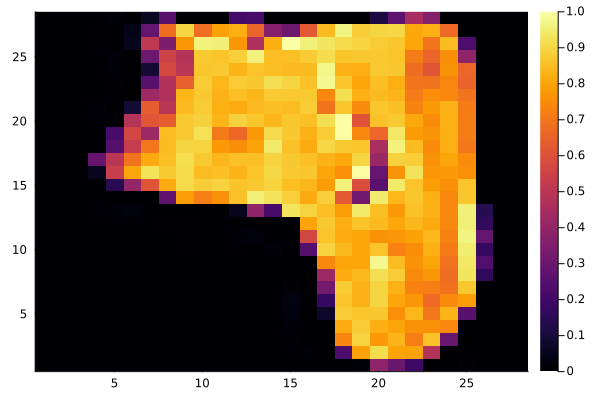

In [15]:
heatmap(x0[:,:,1])

# Test Phasor network

In [16]:
import .PhasorNetworks: default_bias

In [17]:
n_vsa = 128

128

In [80]:
p_model = Chain(LayerNorm((28, 28)),
            x -> reshape(x, (28, 28, 1, :)),
            x -> tanh.(x), 
            x -> x,  #placeholder for makespiking
            PhasorConv((16, 16), 1 => 3, soft_angle),
            PhasorConv((8, 8), 3 => 1, soft_angle),
            FlattenLayer(),
            PhasorDense(36 => n_vsa, soft_angle),
            PhasorDense(n_vsa => n_vsa, soft_angle),
            Codebook(n_vsa => 10),
            )

Chain(
    layer_1 = LayerNorm((28, 28), affine=true, dims=Colon()),  # 1_568 parameters
    layer_2 = WrappedFunction(#55),
    layer_3 = WrappedFunction(#56),
    layer_4 = WrappedFunction(#57),
    layer_5 = PhasorConv(
        layer = Conv((16, 16), 1 => 3, use_bias=false),  # 768 parameters
        bias = ComplexBias((1, 1, 3)),            # 6 parameters
    ),
    layer_6 = PhasorConv(
        layer = Conv((8, 8), 3 => 1, use_bias=false),  # 192 parameters
        bias = ComplexBias((1, 1, 1)),            # 2 parameters
    ),
    layer_7 = FlattenLayer{Nothing}(nothing),
    layer_8 = PhasorDense(
        layer = Dense(36 => 128, use_bias=false),  # 4_608 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_9 = PhasorDense(
        layer = Dense(128 => 128, use_bias=false),  # 16_384 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_10 = Codebook(128 => 10),
)         # Total: 24_040 parameter

In [81]:
psp, stp = Lux.setup(args.rng, p_model, )  .|> gdev

((layer_1 = (bias = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;], scale = Float32[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[-0.05766496 0.08910143 … 0.047003277 0.0139898565; -0.080027506 -0.04998978 … -0.09244675 0.09419803; … ; -0.09271453 0.103725314 … 0.07675693 -0.10073913; 0.07371285 0.016778285 … -0.036770504 -0.014800303;;;; -0.07617716 0.10725441 … -0.038832158 0.043657646; -0.075810574 -0.081823386 … -0.09406755 -0.014487646; … ; -0.049020294 -0.08773717 … -0.045558248 -0.10323291; 0.025260031 0.032799315 … -0.073075496 -0.033021227;;;; -0.094845764 0.051448394 … 0.10673966 -0.077223696; -0.09599363 -0.05307753 … 0.025485748 0.08687767; … ; 0.10436498 -0.036838576 … -0.05724099 -0.03211344; -0.013560799 0.086780466 … -0.043444715 -0.008204564],), bias = (bias_real = Float32[1.0;;; 

In [82]:
yp0, _ = p_model(x0 |> gdev, psp, stp) 

(Float32[-0.05017238 -0.042731836 … -0.07525019 -0.014644292; -0.0044226497 -0.01648516 … 0.0121369865 -0.04638181; … ; -0.08514185 -0.062652834 … -0.12725097 -0.035322413; -0.0057054926 -0.12090611 … 0.00444098 -0.05112181], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = NamedTuple(), bias = NamedTuple()), layer_6 = (layer = NamedTuple(), bias = NamedTuple()), layer_7 = NamedTuple(), layer_8 = (dense = NamedTuple(), bias = NamedTuple()), layer_9 = (dense = NamedTuple(), bias = NamedTuple()), layer_10 = (codes = Float32[-0.7858412 0.48188722 … -0.9994551 -0.010766029; -0.48433197 0.027295947 … 0.64001536 -0.49457848; … ; 0.9962454 -0.3352219 … -0.8205558 0.98155403; -0.455837 0.4745438 … -0.88912165 -0.9085648],)))

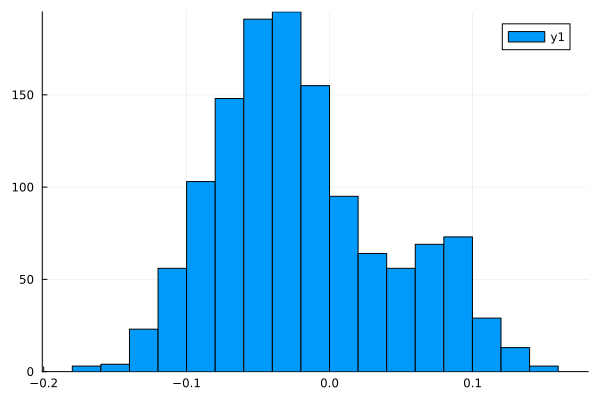

In [83]:
histogram(cdev(vec(yp0)))

In [84]:
function phasor_loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    loss = evaluate_loss(y_pred, y_onehot, :similarity) 
    loss = mean(loss)
    return loss
end

phasor_loss_function (generic function with 1 method)

In [85]:
phasor_loss_function(x0 |> gdev, y0 |> gdev, p_model, psp, stp)

1.0172731313178938

In [86]:
@time losses_f, ps_train_f, st_train_f, grad_samples = train(p_model, psp, stp, train_loader, phasor_loss_function, args, optimiser=RMSProp, sample_gradients=250)

[ Info: Training on CUDA GPU


205.388322 seconds (341.97 M allocations: 15.474 GiB, 1.13% gc time, 1 lock conflict, 1.25% compilation time)


(Any[1.0172731250468456, 1.0068901312732732, 0.9828818279631877, 0.9677562067416664, 0.9731979625088422, 0.9489149641126022, 0.9502456778224082, 0.9188387364204004, 0.9179738197063898, 0.9077854369870996  …  0.13608790293455186, 0.13068368525689478, 0.11247070397968537, 0.1325753768717745, 0.13799652305557775, 0.13502306123718524, 0.14390701212461038, 0.14400718359464904, 0.12245452686142554, 0.10637658833853438], (layer_1 = (bias = Float32[0.029557519 -0.22526543 … 0.015381104 0.16259636; -0.043935318 0.08816681 … -0.1270769 -0.05399526; … ; 0.26262838 0.070921846 … -0.19272281 0.50619453; -0.27475932 0.2027929 … -0.2555977 0.2760063;;;], scale = Float32[0.97335935 1.22127 … 0.990071 0.8324885; 1.0426474 0.9083566 … 1.108223 1.0352747; … ; 0.73190504 0.9216655 … 1.1918087 0.4954289; 1.2731836 0.78726095 … 1.2884637 0.7295893;;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[0.07811248 0.22580297 … 0.055823896 0.046558324

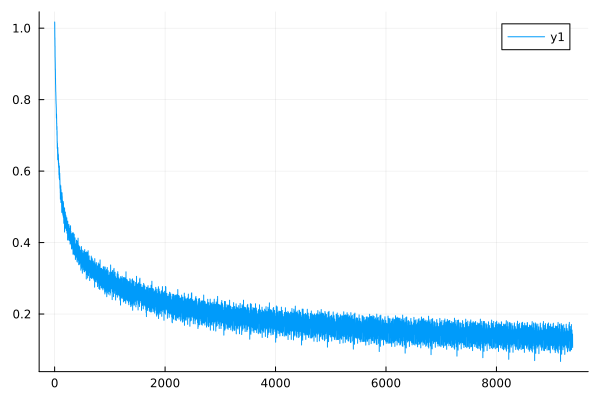

In [87]:
#plot(losses)
plot(losses_f)

In [88]:
yp1, _ = p_model(x0 |> gdev, ps_train_f, st_train_f) 

(Float32[-0.023586532 0.8910072 … 0.06409611 0.604671; 0.009508764 -0.023271626 … 0.057770334 0.12402553; … ; 0.07646511 -0.03217694 … 0.032394193 -0.104529336; 0.9269329 -0.01372206 … 0.005221043 0.055390894], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = NamedTuple(), bias = NamedTuple()), layer_6 = (layer = NamedTuple(), bias = NamedTuple()), layer_7 = NamedTuple(), layer_8 = (dense = NamedTuple(), bias = NamedTuple()), layer_9 = (dense = NamedTuple(), bias = NamedTuple()), layer_10 = (codes = Float32[-0.7858412 0.48188722 … -0.9994551 -0.010766029; -0.48433197 0.027295947 … 0.64001536 -0.49457848; … ; 0.9962454 -0.3352219 … -0.8205558 0.98155403; -0.455837 0.4745438 … -0.88912165 -0.9085648],)))

In [89]:
size(yp1)

(10, 128)

In [28]:
function test_phasor(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = predict(cdev(y_pred), :codebook)
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test_phasor (generic function with 1 method)

In [90]:
test_phasor(p_model, test_loader, ps_train_f, st_train_f)

0.8035

# Inspect gradients

In [31]:
length(grad_samples)

37

In [44]:
function snatch_weight_grads(sample)
    return [sample.layer_5.layer.weight, 
            sample.layer_6.layer.weight,
            sample.layer_8.layer.weight,]
end

snatch_weight_grads (generic function with 1 method)

In [45]:
nn_layer_updates = snatch_weight_grads.(grad_samples);

In [47]:
length(nn_layer_updates)

37

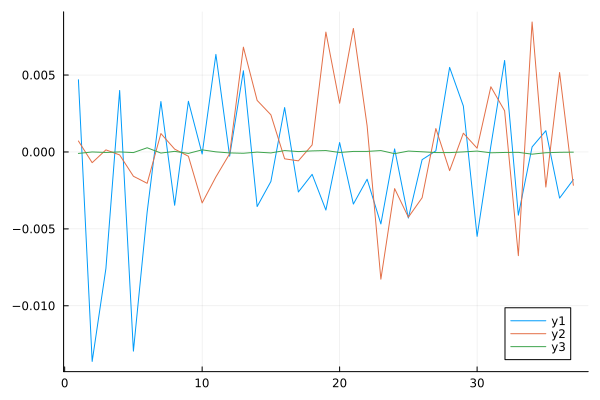

In [49]:
plot(median.(getindex.(nn_layer_updates,1)))
plot!(median.(getindex.(nn_layer_updates,2)))
plot!(median.(getindex.(nn_layer_updates,3)))

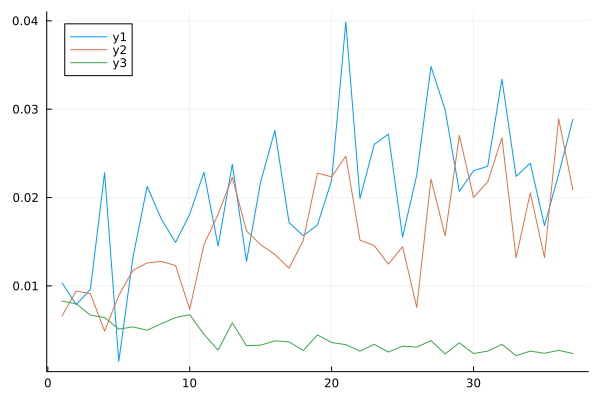

In [63]:
plot(maximum.(getindex.(nn_layer_updates,1)))
plot!(maximum.(getindex.(nn_layer_updates,2)))
plot!(maximum.(getindex.(nn_layer_updates,3)))

# Test conventional network

In [50]:
model = Chain(LayerNorm((28, 28)),
            x -> reshape(x, (28, 28, 1, :)),
            Conv((16, 16), 1 => 3, relu),
            Conv((8, 8), 3 => 1, relu),
            FlattenLayer(),
            Dense(36 => 128, relu),
            Dense(128 => 10),
            softmax)

Chain(
    layer_1 = LayerNorm((28, 28), affine=true, dims=Colon()),  # 1_568 parameters
    layer_2 = WrappedFunction(#47),
    layer_3 = Conv((16, 16), 1 => 3, relu),       # 771 parameters
    layer_4 = Conv((8, 8), 3 => 1, relu),         # 193 parameters
    layer_5 = FlattenLayer{Nothing}(nothing),
    layer_6 = Dense(36 => 128, relu),             # 4_736 parameters
    layer_7 = Dense(128 => 10),                   # 1_290 parameters
    layer_8 = WrappedFunction(softmax),
)         # Total: 8_558 parameters,
          #        plus 0 states.

In [51]:
ps, st = Lux.setup(args.rng, model)

((layer_1 = (bias = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;], scale = Float32[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;;]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.20837525 -0.15843764 … -0.0551671 -0.20225221; -0.07352965 -0.15818547 … -0.007610364 -0.017277958; … ; -0.1047878 -0.13488318 … -0.095326506 -0.1503755; -0.13878295 -0.09476716 … -0.11618115 -0.07567272;;;; -0.19871248 0.011762788 … -0.19372788 0.20005517; -0.053173877 -0.13788196 … 0.08530077 0.00070359465; … ; -0.15069665 0.08567754 … 0.14981146 -0.20313178; 0.20695035 -0.15727153 … -0.077974655 -0.12951344;;;; -0.14242639 -0.03600564 … -0.03301423 -0.17216873; 0.19062933 -0.009635563 … -0.11451465 -0.15774074; … ; -0.044083413 -0.076915406 … -0.06822679 -0.04081796; -0.19119 0.09149123 … -0.012258745 0.14418036], bias = Float32[0.038199797, -0.0041895956, 0.039057262]), layer_4 = (weight = Float32[-0.23890701 -0.104012

In [52]:
size(x0)

(28, 28, 128)

In [53]:
yp, _ = model(x0, ps, st);

In [54]:
yp |> size

(10, 128)

In [55]:
function loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    return CrossEntropyLoss(;logits=false, dims=1)(y_pred, y_onehot)
end

loss_function (generic function with 1 method)

In [56]:
loss_function(x0, y0, model, ps, st)

2.802434f0

In [64]:
losses, pst, stt, c_sample_gradients = train(model, ps |> gdev, st |> gdev, train_loader, loss_function, args, sample_gradients=250)

[ Info: Training on CUDA GPU


(Any[2.802434f0, 2.6607249f0, 2.6479845f0, 2.6547894f0, 2.4742718f0, 2.4956157f0, 2.355135f0, 2.4559743f0, 2.4828024f0, 2.3892424f0  …  0.3715735f0, 0.40229207f0, 0.351754f0, 0.40577644f0, 0.4765805f0, 0.36062938f0, 0.48232913f0, 0.4100473f0, 0.37018114f0, 0.38779917f0], (layer_1 = (bias = Float32[0.20922925 0.31369004 … -0.050069228 -0.30025378; 0.114734225 -0.23743609 … 0.35346568 -0.29478523; … ; 0.19175437 0.24287765 … -0.10339084 0.1351669; -0.1597876 -0.34028533 … 0.07273795 -0.31897333;;;], scale = Float32[0.78297395 0.68421954 … 1.0379578 1.298276; 0.88067997 1.2350194 … 0.58639723 1.2736046; … ; 0.81152594 0.77678335 … 1.2054371 0.8258707; 1.1527854 1.3556204 … 0.9287111 1.3132812;;;]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.00025840467 -0.11824841 … -0.09300634 -0.39499196; 0.12277899 -0.052422017 … -0.10075373 0.028566841; … ; -0.046543024 -0.06500027 … -0.041722283 -0.17050971; 0.009687787 -0.05479327 … -0.31393903 -0.16046767;;;; -0.13817433 0.10911799 … -0

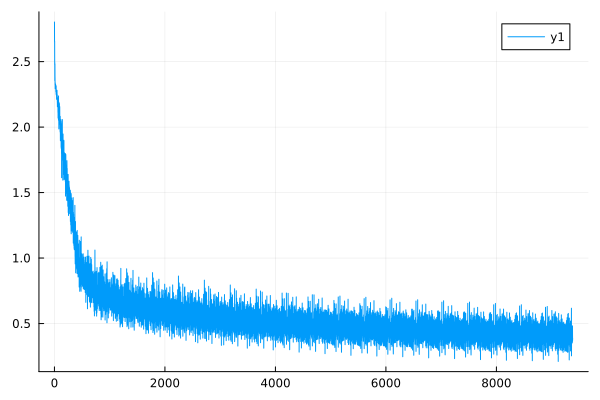

In [65]:
plot(losses)

In [66]:
x1, y1 = first(test_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.003921569 0.0; 0.0 0.0 … 0.0 0.003921569; … ; 0.0 0.0 … 0.0 0.043137256; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 2, 1, 1, 6, 1, 4, 6, 5, 7  …  7, 8, 0, 0, 9, 9, 3, 0, 8, 4])

In [67]:
function test(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = onecold(cdev(y_pred))
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test (generic function with 1 method)

In [68]:
test(model, test_loader, ps |> gdev, st |> gdev)

0.1042

In [69]:
test(model, test_loader, pst, stt)

0.8312

In [75]:
function snatch_weight_grads_c(sample)
    return [sample.layer_3.weight, 
            sample.layer_4.weight,
            sample.layer_6.weight,
            sample.layer_7.weight,]
end

snatch_weight_grads_c (generic function with 1 method)

In [76]:
c_nn_layer_updates = snatch_weight_grads_c.(c_sample_gradients);

In [77]:
length(c_nn_layer_updates)

37

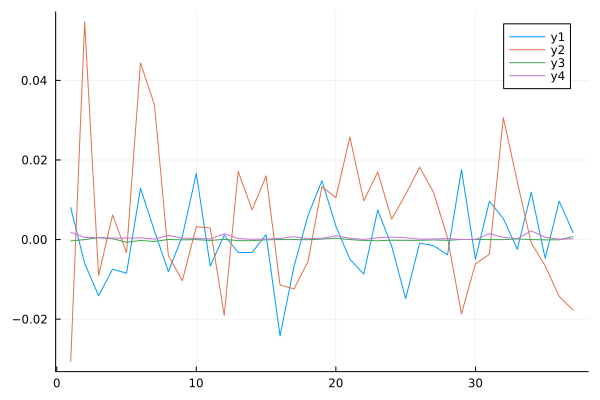

In [78]:
plot(median.(getindex.(c_nn_layer_updates,1)))
plot!(median.(getindex.(c_nn_layer_updates,2)))
plot!(median.(getindex.(c_nn_layer_updates,3)))
plot!(median.(getindex.(c_nn_layer_updates,4)))

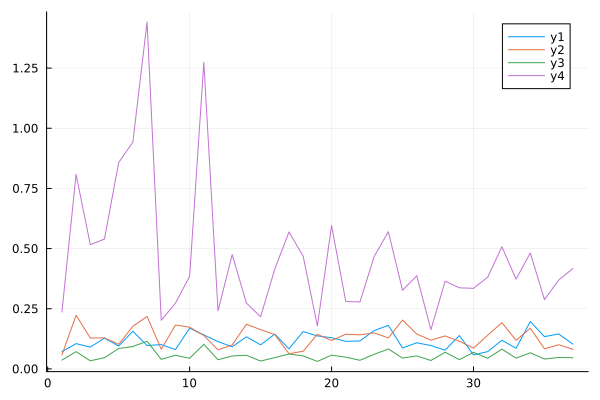

In [79]:
plot(maximum.(getindex.(c_nn_layer_updates,1)))
plot!(maximum.(getindex.(c_nn_layer_updates,2)))
plot!(maximum.(getindex.(c_nn_layer_updates,3)))
plot!(maximum.(getindex.(c_nn_layer_updates,4)))

# Test spiking behavior

In [ ]:
spk_model = Chain(LayerNorm((28, 28)),
            x -> reshape(x, (28, 28, 1, :)),
            x -> tanh.(x), 
            MakeSpiking(spk_args, repeats),
            PhasorConv((16, 16), 1 => 3, soft_angle),
            PhasorConv((8, 8), 3 => 1, soft_angle),
            FlattenLayer(),
            PhasorDense(36 => 128, soft_angle),
            PhasorDense(128 => 10, soft_angle),
            )
            

Chain(
    layer_1 = LayerNorm((28, 28), affine=true, dims=Colon()),  # 1_568 parameters
    layer_2 = WrappedFunction(#39),
    layer_3 = WrappedFunction(#40),
    layer_4 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0f0, 20.0f0), 0.0f0),
    layer_5 = PhasorConv(
        layer = Conv((16, 16), 1 => 3, use_bias=false),  # 768 parameters
        bias = ComplexBias((1, 1, 3)),            # 6 parameters
    ),
    layer_6 = PhasorConv(
        layer = Conv((8, 8), 3 => 1, use_bias=false),  # 192 parameters
        bias = ComplexBias((1, 1, 1)),            # 2 parameters
    ),
    layer_7 = FlattenLayer{Nothing}(nothing),
    layer_8 = PhasorDense(
        layer = Dense(36 => 128, use_bias=false),  # 4_608 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_9 = PhasorDense(
        layer = Dense(128 => 10, use_bias=false),  # 1_280 parameters
        bias = ComplexBias((10,)),   

In [ ]:
spk_args.solver_args[:dt]

0.01f0

In [ ]:
ps0t, st0t = Lux.setup(args.rng, spk_model) .|> gdev

((layer_1 = (bias = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;], scale = Float32[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[-0.05766496 0.08910143 … 0.047003277 0.0139898565; -0.080027506 -0.04998978 … -0.09244675 0.09419803; … ; -0.09271453 0.103725314 … 0.07675693 -0.10073913; 0.07371285 0.016778285 … -0.036770504 -0.014800303;;;; -0.07617716 0.10725441 … -0.038832158 0.043657646; -0.075810574 -0.081823386 … -0.09406755 -0.014487646; … ; -0.049020294 -0.08773717 … -0.045558248 -0.10323291; 0.025260031 0.032799315 … -0.073075496 -0.033021227;;;; -0.094845764 0.051448394 … 0.10673966 -0.077223696; -0.09599363 -0.05307753 … 0.025485748 0.08687767; … ; 0.10436498 -0.036838576 … -0.05724099 -0.03211344; -0.013560799 0.086780466 … -0.043444715 -0.008204564],), bias = (bias_real = Float32[1.0;;; 

In [ ]:
typeof(x0)

Array{Float32, 3}

In [ ]:
ps0t.layer_5.layer

(weight = Float32[-0.05766496 0.08910143 … 0.047003277 0.0139898565; -0.080027506 -0.04998978 … -0.09244675 0.09419803; … ; -0.09271453 0.103725314 … 0.07675693 -0.10073913; 0.07371285 0.016778285 … -0.036770504 -0.014800303;;;; -0.07617716 0.10725441 … -0.038832158 0.043657646; -0.075810574 -0.081823386 … -0.09406755 -0.014487646; … ; -0.049020294 -0.08773717 … -0.045558248 -0.10323291; 0.025260031 0.032799315 … -0.073075496 -0.033021227;;;; -0.094845764 0.051448394 … 0.10673966 -0.077223696; -0.09599363 -0.05307753 … 0.025485748 0.08687767; … ; 0.10436498 -0.036838576 … -0.05724099 -0.03211344; -0.013560799 0.086780466 … -0.043444715 -0.008204564],)

In [ ]:
ps0t.layer_5.bias

(bias_real = Float32[1.0;;; 1.0;;; 1.0], bias_imag = Float32[0.0;;; 0.0;;; 0.0])

In [ ]:
size(x0)

(28, 28, 128)

In [ ]:
ys0, _ = spk_model(x0 |> gdev, ps0t , st0t)

(SpikingCall(SpikeTrainGPU{2}(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(1, 128), CartesianIndex(2, 128), CartesianIndex(3, 128), CartesianIndex(4, 128), CartesianIndex(5, 128), CartesianIndex(6, 128), CartesianIndex(7, 128), CartesianIndex(8, 128), CartesianIndex(9, 128), CartesianIndex(10, 128)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280], Float32[2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039  …  21.005032, 21.490557, 21.502773, 21.00009, 21.513708, 21.25359, 21.504688, 21.009766, 21.005306, 21.997334], (10, 128), 1280, 1.0f0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 20.0f0)), (layer_1 = NamedTuple(), layer_2 = N

In [ ]:
ys0.train.shape

(10, 128)

In [ ]:
train_to_phase(ys0) |> size

(20, 10, 128)

In [ ]:
ys0.train

SpikeTrainGPU{2}(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(1, 128), CartesianIndex(2, 128), CartesianIndex(3, 128), CartesianIndex(4, 128), CartesianIndex(5, 128), CartesianIndex(6, 128), CartesianIndex(7, 128), CartesianIndex(8, 128), CartesianIndex(9, 128), CartesianIndex(10, 128)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280], Float32[2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039  …  21.005032, 21.490557, 21.502773, 21.00009, 21.513708, 21.25359, 21.504688, 21.009766, 21.005306, 21.997334], (10, 128), 1280, 1.0f0)

In [ ]:
ys0.t_span

(0.0f0, 20.0f0)

In [ ]:
function fmnist_spiking_accuracy(data_loader, model, ps, st, args)
    acc = []
    n_phases = []
    num = 0

    n_batches = length(data_loader)

    for (x, y) in data_loader
        if args.use_cuda && CUDA.functional()
            x = x |> gdev
            y = gdev(1.0f0 .* onehotbatch(y, 0:9))
        end
        
        spk_output, _ = model(x, ps, st)
        ŷ = train_to_phase(spk_output)
        
        push!(acc, sum.(accuracy_quadrature(ŷ, y))) ## Decode the output of the model
        num += size(x)[end]
    end

    #acc = sum(reshape(acc, :, n_batches), dims=2) ./ num 
    return acc, num
end

fmnist_spiking_accuracy (generic function with 1 method)

In [ ]:
spk_a, spk_n = fmnist_spiking_accuracy(test_loader, spk_model, ps_train_f, st_train_f, args)

(Any[[12, 12, 15, 56, 90, 103, 107, 107, 108, 109, 108, 108, 108, 109, 109, 107, 107, 107, 107, 16], [9, 9, 13, 46, 89, 108, 109, 110, 111, 112, 112, 113, 113, 112, 112, 112, 111, 112, 112, 17], [9, 9, 16, 46, 87, 108, 109, 110, 111, 111, 111, 112, 112, 112, 113, 112, 111, 111, 111, 14], [10, 10, 15, 57, 86, 101, 103, 102, 106, 106, 106, 106, 107, 107, 107, 107, 107, 108, 108, 16], [10, 10, 15, 48, 82, 102, 103, 104, 103, 104, 105, 104, 104, 104, 104, 104, 104, 104, 104, 19], [11, 11, 18, 63, 94, 100, 104, 104, 104, 103, 103, 102, 102, 102, 104, 104, 104, 104, 103, 17], [14, 14, 12, 44, 85, 105, 111, 110, 111, 111, 113, 114, 114, 114, 115, 115, 115, 115, 115, 10], [16, 16, 15, 50, 82, 102, 102, 104, 105, 104, 104, 104, 105, 104, 103, 104, 104, 104, 104, 20], [16, 16, 14, 52, 91, 102, 103, 105, 107, 108, 108, 107, 107, 108, 108, 108, 108, 109, 108, 23], [13, 13, 17, 48, 87, 98, 99, 99, 100, 102, 102, 102, 103, 103, 102, 101, 100, 99, 100, 21]  …  [7, 7, 17, 41, 78, 94, 101, 100, 100, 10

In [ ]:
l2 = [x[1:20] for x in spk_a] |> stack;

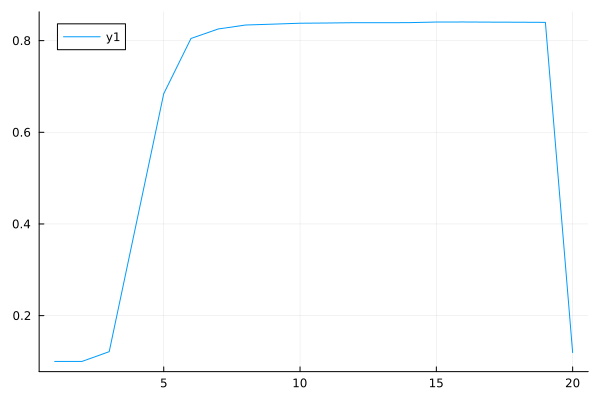

In [ ]:
plot(sum(l2, dims=2) ./ spk_n)